In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,load_img,img_to_array

import tqdm
from tqdm import tqdm_notebook,tnrange

from skimage.transform import resize

from sklearn.model_selection import train_test_split

import os
import numpy as np
import pandas as pd
from PIL import Image


In [2]:
import os

Train_Image_folder = "Dataset salt/train/train_images/images/"
Train_Mask_folder = "Dataset salt/train/train_masks/masks/"
Test_Image_folder = "Dataset salt/test/images/"
Train_Image_name = os.listdir(Train_Image_folder)
Test_Image_name = os.listdir(Test_Image_folder)
Train_Image_path = []
Train_Mask_path = []
Train_id = []

for i in Train_Image_name:
    path1 = Train_Image_folder + i
    path2 = Train_Mask_folder + i
    id1 = i.split(sep='.')[0]
    Train_Image_path.append(path1)
    Train_Mask_path.append(path2)
    Train_id.append(id1)
    
Test_Image_path = []
Test_id = []

for i in Test_Image_name:
    path = Test_Image_folder + i
    id2 = i.split(sep='.')[0]
    Test_Image_path.append(path)
    Test_id.append(id2)
    
df_Train_path = pd.DataFrame({'id': Train_id, 'Train_Image_path': Train_Image_path, 'Train_Mask_path': Train_Mask_path})
df_Test_path = pd.DataFrame({'id': Test_id, 'Test_Image_path': Test_Image_path})
    
df_depths = pd.read_csv('./depths.csv')
df_sub = pd.read_csv('./sample_submission.csv')
df_Train_path = df_Train_path.merge(df_depths, on='id', how='left')
df_Test_path = df_Test_path.merge(df_depths, on='id', how='left')
df_Test_path = df_sub.merge(df_Test_path, on='id', how='left')

print(df_Train_path.shape, df_Test_path.shape)
df_Train_path.head()

(4000, 4) (18000, 4)


,id,Train_Image_path,Train_Mask_path,z
0,000e218f21,Dataset salt/train/train_images/images/000e218...,Dataset salt/train/train_masks/masks/000e218f2...,841
1,003c477d7c,Dataset salt/train/train_images/images/003c477...,Dataset salt/train/train_masks/masks/003c477d7...,673
2,00441f1cf2,Dataset salt/train/train_images/images/00441f1...,Dataset salt/train/train_masks/masks/00441f1cf...,330
3,0050766ae2,Dataset salt/train/train_images/images/0050766...,Dataset salt/train/train_masks/masks/0050766ae...,835
4,005b452274,Dataset salt/train/train_images/images/005b452...,Dataset salt/train/train_masks/masks/005b45227...,657


In [3]:
df_Test_path.head()

,id,rle_mask,Test_Image_path,z
0,155410d6fa,1 1,Dataset salt/test/images/155410d6fa.png,559
1,78b32781d1,1 1,Dataset salt/test/images/78b32781d1.png,298
2,63db2a476a,1 1,Dataset salt/test/images/63db2a476a.png,392
3,17bfcdb967,1 1,Dataset salt/test/images/17bfcdb967.png,698
4,7ea0fd3c88,1 1,Dataset salt/test/images/7ea0fd3c88.png,837


In [4]:
def read_image(path, img_height, img_width, img_chan):
    pixel = np.zeros((len(path), img_height, img_width, img_chan), dtype=np.float32)
    
    for n, p in tqdm_notebook(enumerate(path), total=len(path)):

        img = load_img(p)
        x = img_to_array(img)[:,:,1]
        x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
        x = x / 255
        pixel[n]= x
        
    return pixel

img_height = 128
img_width = 128
img_chan = 1
Train_Image_pixel = read_image(df_Train_path.Train_Image_path, img_height, img_width, img_chan)
Train_Mask_pixel = read_image(df_Train_path.Train_Mask_path, img_height, img_width, img_chan)

print('Train Image shape: ',Train_Image_pixel.shape)
print('Train Mask shape: ',Train_Mask_pixel.shape)

<ipython-input-4-ae0a098f7148>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, p in tqdm_notebook(enumerate(path), total=len(path)):


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Train Image shape:  (4000, 128, 128, 1)
Train Mask shape:  (4000, 128, 128, 1)


In [5]:
def read_image2(path,img_height,img_width,img_chan):
    pixel=np.zeros((len(path), img_height, img_width, img_chan),dtype=np.float32)
    sizes_test = []
    for n, p in tqdm_notebook(enumerate(path), total=len(path)):
        img = load_img(p)
        x = img_to_array(img)[:,:,1]
        sizes_test.append([x.shape[0], x.shape[1]])
        x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
        x=x/255
        pixel[n]=x
    return pixel,sizes_test

Test_Image_pixel,sizes_test=read_image2(df_Test_path.Test_Image_path,img_height,img_width,img_chan)
print('Test Image shape: ',Test_Image_pixel.shape)

<ipython-input-5-2f7a7c5e9759>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, p in tqdm_notebook(enumerate(path), total=len(path)):


  0%|          | 0/18000 [00:00<?, ?it/s]

Test Image shape:  (18000, 128, 128, 1)


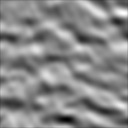

In [6]:
array_to_img(Train_Image_pixel[0])

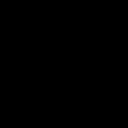

In [7]:
array_to_img(Train_Mask_pixel[0])

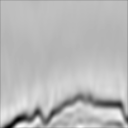

In [8]:
array_to_img(Test_Image_pixel[0])

In [9]:
X=Train_Image_pixel
Y=Train_Mask_pixel
test=Test_Image_pixel
X_train,X_val,y_train,y_val=train_test_split(X,Y,test_size=0.20,random_state=42)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(test.shape)

(3200, 128, 128, 1) (3200, 128, 128, 1)
(800, 128, 128, 1) (800, 128, 128, 1)
(18000, 128, 128, 1)


In [10]:
def unet(pretrained_weights = None,input_size = (img_height,img_width,img_chan)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv10 = Conv2D(3, 3, activation = 'softmax', padding = 'same')(conv9)
    
    #flatten = Flatten()(conv10)
    
    #dense = Dense(1024, activation = 'relu', kernel_initializer = 'he_normal')(flatten)
    
    #dense2 = Dense(2, activation = 'softmax')(dense)
    
    model = Model(inputs, conv10)

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)
        
    return model

keras.backend.clear_session()

# Build model
model = unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [11]:
inputs = Input((img_height, img_width, img_chan))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')
#model.summary()

In [12]:
callbacks = [
    ModelCheckpoint("saltSegmentation.h5", save_best_only=True),
    EarlyStopping(monitor='val_loss', mode='min', patience=3),
    ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=4)
]

epochs = 15
results = model.fit(X, Y, epochs=epochs, batch_size=32, validation_split=0.1, callbacks=callbacks)

Epoch 1/15
113/113 [==============================] - 99s 875ms/step - loss: 0.6237 - val_loss: 0.5427
Epoch 2/15
113/113 [==============================] - 104s 916ms/step - loss: 0.5674 - val_loss: 0.5334
Epoch 3/15
113/113 [==============================] - 107s 948ms/step - loss: 0.5582 - val_loss: 0.5147
Epoch 4/15
113/113 [==============================] - 103s 912ms/step - loss: 0.5120 - val_loss: 0.4358
Epoch 5/15
113/113 [==============================] - 103s 909ms/step - loss: 0.4399 - val_loss: 0.3697
Epoch 6/15
113/113 [==============================] - 99s 874ms/step - loss: 0.3903 - val_loss: 0.3745
Epoch 7/15
113/113 [==============================] - 97s 861ms/step - loss: 0.3633 - val_loss: 0.3444
Epoch 8/15
113/113 [==============================] - 106s 937ms/step - loss: 0.3460 - val_loss: 0.3201
Epoch 9/15
113/113 [==============================] - 98s 863ms/step - loss: 0.3334 - val_loss: 0.2776
Epoch 10/15
113/113 [==============================] - 98s 863ms/ste

In [13]:
def display2(img):
    plt.figure(figsize=(5,5))
    img = np.squeeze(img)
    plt.imshow(img)
    plt.show()

In [54]:
model = load_model('saltSegmentationKaggle.h5')

In [55]:
img = test[0:100]
#img_batch = np.expand_dims(img, axis=0)
prediction = model.predict(img)


In [56]:
prediction.shape

(100, 128, 128, 1)

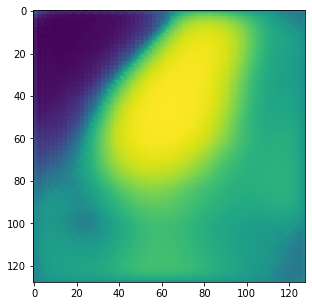

In [60]:
display2(prediction[1])

In [34]:
img2 = test[0]
img_batch2 = np.expand_dims(img2, axis=0)
prediction2 = model.predict(img_batch2)


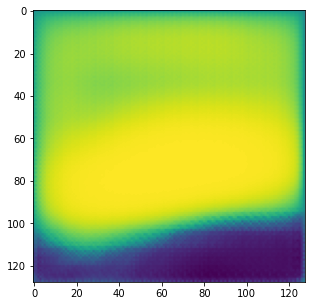

In [35]:
display2(prediction2)